In [1]:
import numpy as np
import pandas as pd
from pygam import LinearGAM, s, f, l
import matplotlib.pyplot as plt
from quantbullet.model import WrapperGAM
from quantbullet.model.feature import FeatureSpec, FeatureRole, Feature, DataType

# Generate sample data
np.random.seed(42)
n_samples = 200

# Create features
age = np.random.uniform(20, 80, n_samples)
income = np.random.uniform(20000, 120000, n_samples)
education = np.random.uniform(8, 20, n_samples)
level = np.random.choice(['highschool', 'bachelor', 'master', 'phd'], n_samples)

# Create target with non-linear relationships
happiness = (
    0.5 * np.sin((age - 40) / 10) +  # non-linear relationship with age
    0.3 * np.log(income / 30000) +   # log relationship with income
    0.2 * education +                # linear relationship with education
    0.1 * (level == 'phd').astype(float) +  # categorical effect
    np.random.normal(0, 0.5, n_samples)  # noise
)

# Create DataFrame
data = pd.DataFrame({
    'age': age,
    'income': income,
    'education': education,
    'level': level,
    'happiness': happiness
})

print("Sample data:")
print(data.head())

Sample data:
         age         income  education       level  happiness
0  42.472407   84203.164615   9.237486  highschool   1.953555
1  77.042858   28413.996500  18.830635    bachelor   3.506799
2  63.919637   36162.871409  14.063028         phd   2.879133
3  55.919509  109855.418853  17.917490    bachelor   4.280499
4  29.361118   80642.905966  11.840595  highschool   2.730791


In [2]:
features = FeatureSpec(
    features=[
        Feature(name='age', dtype=DataType.FLOAT, role=FeatureRole.MODEL_INPUT, specs={ "spline_order" : 3, "n_splines" : 6, "lam" : 0.1, "by" : "level" }),
        Feature(name='income', dtype=DataType.FLOAT, role=FeatureRole.MODEL_INPUT, specs={ "spline_order" : 3, "n_splines" : 6, "lam" : 0.1 } ),
        Feature(name='education', dtype=DataType.FLOAT, role=FeatureRole.MODEL_INPUT, specs={ "spline_order" : 3, "n_splines" : 6, "lam" : 0.1 } ),
        Feature(name='level', dtype=DataType.CATEGORICAL, role=FeatureRole.SECONDARY_INPUT ),
        Feature( name='happiness', dtype=DataType.FLOAT, role=FeatureRole.TARGET )
    ]
)

In [3]:
wgam = WrapperGAM( features )
wgam.fit( data, data['happiness'] )

WrapperGAM( LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=te(0, 3) + s(1) + s(2) + intercept,
   tol=0.0001, verbose=False) )

(<Figure size 1500x400 with 3 Axes>,
 array([<Axes: xlabel='age, by = level', ylabel='Partial Dependence'>,
        <Axes: xlabel='income', ylabel='Partial Dependence'>,
        <Axes: xlabel='education', ylabel='Partial Dependence'>],
       dtype=object))

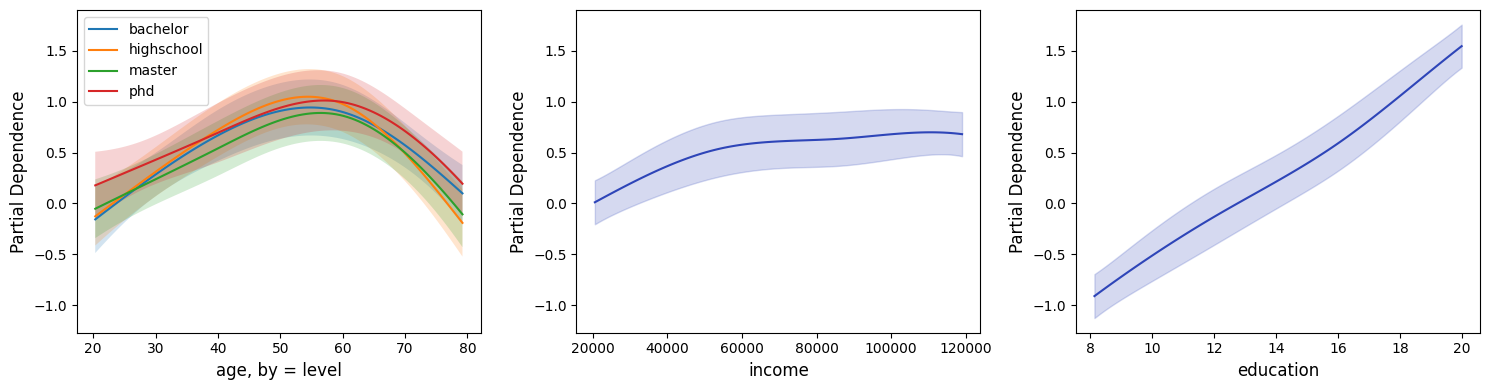

In [4]:
wgam.plot_partial_dependence()